In [131]:
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn
import json
import pandas as pd
import re
from vaderSentiment.vaderSentiment import sentiment as vaderSentiment
from nltk.corpus import stopwords

%matplotlib inline

In [2]:
tweets = []
with open("filtered") as f:
    for line in f.readlines():
        tweets.append(json.loads(line))
        
dataset = pd.DataFrame(tweets)

In [3]:
dataset['screen_name'] = dataset.user.map(lambda x: x['screen_name'].lower())
dataset['name'] = dataset.user.map(lambda x: x['name'].lower())
dataset['statuses_count'] = dataset.user.map(lambda x: x['statuses_count'])
dataset['followers_count'] = dataset.user.map(lambda x: x['followers_count'])
dataset['text_lower'] = dataset.text.apply(lambda x: x.lower())

In [4]:
ge_accounts = ['generalelectric', 
               'ge_reports', 
               'gedobrasil', 
               'ge_canada', 
               'gehealthcare', 
               'ge_digital', 
               'gedesign', 
               'ge_water', 
               'gecareeers_latam', 
               'geaviation', 
               'ge_appliances', 
               'gepublicaffairs', 
               'gecapital', 
               'ge_uk', 
               'geinfosec', 
               'ge_power', 
               'geresearch', 
               'ge_oilandgas', 
               'gelighting', 
               'ge_foundation', 
               'ge_gaspower',
               'ge_grid']
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 36 columns):
contributors                 0 non-null object
coordinates                  0 non-null object
created_at                   418 non-null object
entities                     418 non-null object
extended_entities            222 non-null object
favorite_count               418 non-null int64
favorited                    418 non-null bool
filter_level                 418 non-null object
geo                          0 non-null object
id                           418 non-null int64
id_str                       418 non-null object
in_reply_to_screen_name      11 non-null object
in_reply_to_status_id        5 non-null float64
in_reply_to_status_id_str    5 non-null object
in_reply_to_user_id          11 non-null float64
in_reply_to_user_id_str      11 non-null object
is_quote_status              418 non-null bool
lang                         418 non-null object
place                        6

In [5]:
# Volume
volume_dict = {}

# Tweets by GE
ge_tweets = dataset[dataset['screen_name'].isin(ge_accounts)]
volume_dict["tweets-by-ge"] = len(ge_tweets)

# Followers and tweet count per account
volume_dict['accounts'] = {}
ge_tweets_unique = ge_tweets.drop_duplicates(subset='screen_name')
ge_tweets_unique = ge_tweets_unique[['name', 'screen_name', 'statuses_count', 'followers_count']]
for index, row in ge_tweets_unique.iterrows():
    volume_dict['accounts'][row['screen_name']] = {
        'name': row['name'],
        'tweets': row['statuses_count'],
        'followers': row['followers_count'] 
    }
         
# Function to get counts per element
def get_counts(elem_list, volume_dict, dataset, key):
    current_count = 0
    total_count = 0
    for elem in elem_list:
        current_count = len(dataset[dataset['text_lower'].str.contains(elem)])
        volume_dict[key][elem] = current_count
        total_count += current_count
    return total_count

# Function to get counts for a regex
def get_regex_counts(volume_dict, dataset, key, regex, regexstr):
    count = len(dataset[dataset['text_lower'].str.match(regex)])
    volume_dict[key][regexstr] = count
    return count

# Dataset excluding GE's accounts
exclude_ge = dataset[~dataset['screen_name'].isin(ge_accounts)]
    
# Mentions of GE accounts
volume_dict['mentions'] = {}
ge_mentions = list(ge_accounts)
ge_mentions = ['@{0}'.format(account) for account in ge_mentions]
ge_regex = re.compile('@ge | @ge$')
total_mentions = get_counts(ge_mentions, volume_dict, exclude_ge, 'mentions')
total_mentions += get_regex_counts(volume_dict, exclude_ge, 'mentions', ge_regex, "@ge")
volume_dict['total_mentions'] = total_mentions

# Hashtags of GE
volume_dict['hashtags'] = {}
ge_hashtags = list(ge_accounts)
ge_hashtags = ['#{0}'.format(account) for account in ge_hashtags]
ge_hashtags.append("#general_electric")
ge_hashtag_regex = re.compile('#ge | #ge$')
ge_dollar_regex = re.compile('\$ge | \$ge$')
total_hashtags = get_counts(ge_hashtags, volume_dict, exclude_ge, 'hashtags')
total_hashtags = get_regex_counts(volume_dict, exclude_ge, 'hashtags', ge_dollar_regex, "$ge")
total_hashtags = get_regex_counts(volume_dict, exclude_ge, 'hashtags', ge_hashtag_regex, "#ge")
volume_dict['total_hashtags'] = total_hashtags

# GE mentioned in text
volume_dict['text_mentions'] = {}
ge_text = ['general electric', 'generalelectric']
ge_website_regex = re.compile('ge.com | ge.com$')
total_hashtags = get_counts(ge_text, volume_dict, exclude_ge, 'text_mentions')
total_hashtags += get_regex_counts(volume_dict, exclude_ge, 'text_mentions', ge_website_regex, "ge.com")
volume_dict['total_text_mentions'] = total_hashtags

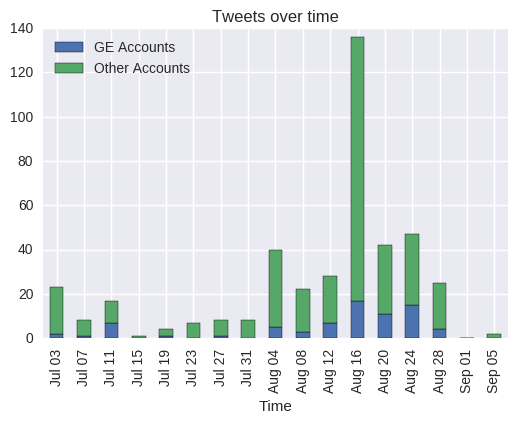

In [117]:
# Volume of tweets over time (ge tweets stacked over other tweets)

dataset_dates = pd.DataFrame()
dataset_dates['GE Accounts'] = pd.Series(dataset['screen_name'].map(lambda x: 1 if x in ge_accounts else 0))
dataset_dates['Other Accounts'] = pd.Series(dataset['screen_name'].map(lambda x: 0 if x in ge_accounts else 1))
dataset_dates['Time'] = pd.Series(dataset['created_at'].map(pd.to_datetime))
dataset_dates = dataset_dates.set_index('Time')

dataset_dates = dataset_dates.resample('4D').sum()
dataset_plot = dataset_dates.plot(kind='bar', stacked=True, title='Tweets over time')
formatted_ticks = dataset_dates.index.map(lambda t: t.strftime('%b %d'))
dataset_plot.set_xticklabels(formatted_ticks)
dataset_plot


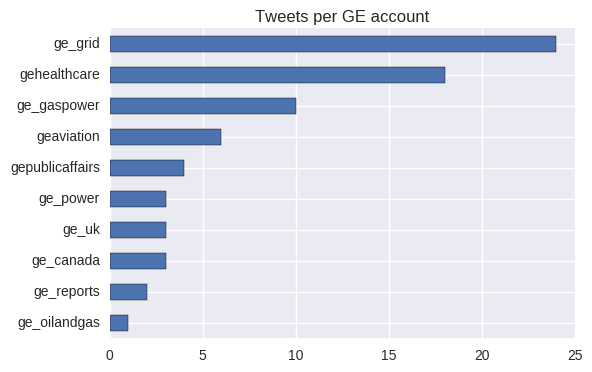

In [126]:
# Volume of tweets per GE account

fig, ax = plt.subplots()
ge_tweets['screen_name'].value_counts().sort_values().plot(ax=ax, kind='barh', title='Tweets per GE account')

In [24]:
# Reach

# All tweets made by GE
ge_tweets = dataset[dataset['screen_name'].isin(ge_accounts)]
ge_tweets['followers_count'] = ge_tweets.user.map(lambda x: x['followers_count'])
ge_tweets = ge_tweets[['id', 'screen_name', 'retweet_count', 'followers_count', 'favorite_count']]

# GE retweeters
exclude_ge = dataset[~dataset['screen_name'].isin(ge_accounts)]
ge_retweets = ['^rt @{0}'.format(account) for account in ge_accounts]
ge_retweeters = dataset[dataset['text_lower'].str.contains('|'.join(ge_retweets))]
ge_retweeters = ge_retweeters[~ge_retweeters['retweeted_status'].isnull()]
ge_retweeters['original_tweet_id'] = ge_retweeters.retweeted_status.map(lambda x: x['id'])
ge_retweeters['followers_count'] = ge_retweeters.user.map(lambda x: x['followers_count'])
ge_retweeters = ge_retweeters[['original_tweet_id', 'followers_count', 'favorite_count']]

# Calculate reach by summing followers of each retweeter
retweet_reach = ge_retweeters.groupby('original_tweet_id')
retweet_reach = retweet_reach.aggregate([np.sum])

# Join the reach results to the original tweets
reach = pd.merge(ge_tweets, retweet_reach, left_on='id', right_index=True, how='left')
reach.columns = ['id', 
                 'screen_name', 
                 'retweet_count', 
                 'followers_count', 
                 'favorite_count', 
                 'retweet_followers',
                 'retweet_favorites',
                ]
reach = reach.fillna(0)
reach['total_favorites'] = reach['retweet_favorites'] + reach['favorite_count']
reach['total_impressions'] = reach['retweet_followers'] + reach['followers_count']

# Group results by account
reach_per_account = reach.drop('id', 1)
reach_per_account = reach.groupby('screen_name')
reach_per_account = reach_per_account.aggregate([np.sum, np.mean, np.std]).sort_values(('total_impressions', 'sum'))
reach_per_account

/home/nloyola/anaconda2/envs/ge-olympics/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


id                                   retweet_count  \
                          sum                mean           std           sum   
screen_name                                                                     
ge_uk            2.301776e+18  767258812436884096  1.777028e+15             0   
ge_gaspower      7.606189e+18  760618873260301952  5.975801e+15             0   
ge_oilandgas     7.659619e+17  765961857089798144           NaN             0   
gepublicaffairs  3.064172e+18  766042993980687360  2.567521e+15             0   
ge_power         2.265132e+18  755044046644177536  5.833353e+15             0   
ge_canada        2.295650e+18  765216653315537536  4.593505e+13             0   
ge_grid          1.836504e+19  765209820014999680  4.745082e+15             0   
ge_reports       1.527838e+18  763918940223518720  3.319889e+15             0   
geaviation       4.619451e+18  769908492773660672  7.466639e+14             0   
gehealthcare     1.376424e+19  764679952393735936  5.974638e+15             0   

                          followers_count                             \
                mean  std             sum           mean         std   
screen_name                                                            
ge_uk              0  0.0            7971    2657.000000   18.357560   
ge_gaspower        0  0.0           31413    3141.300000   94.591578   
ge_oilandgas       0  NaN           41246   41246.000000         NaN   
gepublicaffairs    0  0.0           38359    9589.750000   22.126530   
ge_power           0  0.0           43803   14601.000000  209.401528   
ge_canada          0  0.0           49678   16559.333333    1.154701   
ge_grid            0  0.0          101801    4241.708333   53.446014   
ge_reports         0  0.0          112231   56115.500000   98.287843   
geaviation         0  0.0          878681  146446.833333   63.407939   
gehealthcare       0  0.0         1441424   80079.111111  793.871666   

                favorite_count     ...      retweet_followers  \
                           sum     ...                    std   
screen_name                        ...                          
ge_uk                        0     ...            2754.538134   
ge_gaspower                  0     ...               0.000000   
ge_oilandgas                 0     ...                    NaN   
gepublicaffairs              0     ...            2026.517765   
ge_power                     0     ...            3274.033343   
ge_canada                    0     ...            3387.314029   
ge_grid                      0     ...            1845.199396   
ge_reports                   0     ...            2243.649817   
geaviation                   0     ...            1877.073334   
gehealthcare                 0     ...            3347.390758   

                retweet_favorites           total_favorites            \
                              sum mean  std             sum mean  std   
screen_name                                                             
ge_uk                         0.0  0.0  0.0             0.0  0.0  0.0   
ge_gaspower                   0.0  0.0  0.0             0.0  0.0  0.0   
ge_oilandgas                  0.0  0.0  NaN             0.0  0.0  NaN   
gepublicaffairs               0.0  0.0  0.0             0.0  0.0  0.0   
ge_power                      0.0  0.0  0.0             0.0  0.0  0.0   
ge_canada                     0.0  0.0  0.0             0.0  0.0  0.0   
ge_grid                       0.0  0.0  0.0             0.0  0.0  0.0   
ge_reports                    0.0  0.0  0.0             0.0  0.0  0.0   
geaviation                    0.0  0.0  0.0             0.0  0.0  0.0   
gehealthcare                  0.0  0.0  0.0             0.0  0.0  0.0   

                total_impressions                              
                              sum           mean          std  
screen_name                                                    
ge_uk                     12742.0    4247.333333

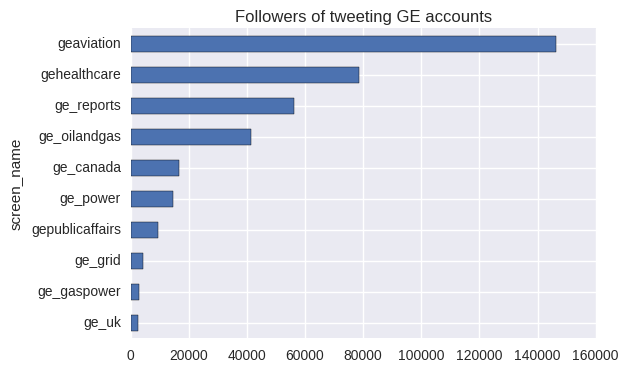

In [119]:
# Followers per GE account
# There are no tweets from the main General Electric account
fig, ax = plt.subplots()
ge_account_followers = ge_tweets.groupby('screen_name').first().sort_values('followers_count')
ge_account_followers['followers_count'].plot(ax=ax, kind='barh', title='Followers of tweeting GE accounts')

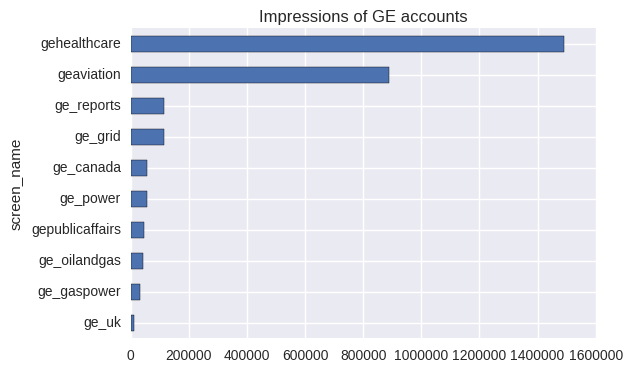

In [120]:
# Reach of GE accounts

fig, ax = plt.subplots()
reach_per_account[('total_impressions', 'sum')].plot(ax=ax, kind='barh', title='Impressions of GE accounts')

In [37]:
# Audience characteristics

# Most active participants
top_participants = exclude_ge[['screen_name', 'text_lower']].groupby('screen_name').agg('count').rename(columns={'text_lower': 'tweet_count'}).sort_values(by='tweet_count', ascending=False)

# Most relevant participants
relevant_participants = exclude_ge[['screen_name', 'followers_count']].groupby('screen_name').agg('max')
relevant_participants = pd.merge(relevant_participants, top_participants, left_index=True, right_index=True, how='left')
relevant_participants['impressions'] = relevant_participants['followers_count'] * relevant_participants['tweet_count']
relevant_participants = relevant_participants.sort_values(by='impressions', ascending=False)
relevant_participants

,followers_count,tweet_count,impressions
screen_name,,,
prweekuknews,63902,2,127804
zain_verjee,67259,1,67259
bbdony,18962,2,37924
findsfromyester,37643,1,37643
sportsfeatures,34532,1,34532
cfm_engines,32736,1,32736
lkafle,31583,1,31583
sporttechie,17023,1,17023
ttamaremo,4249,3,12747


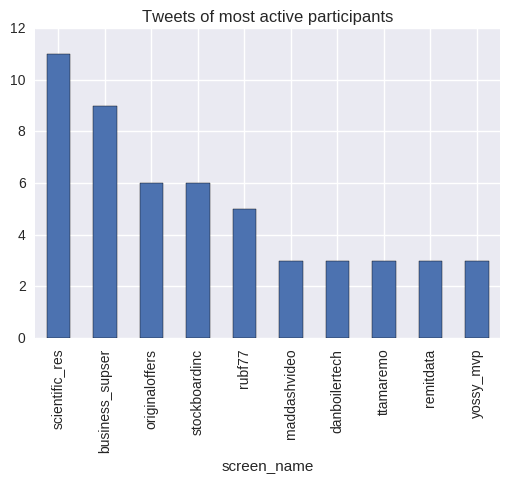

In [121]:
# Most active participants

fig, ax = plt.subplots()
top_participants['tweet_count'].head(10).plot(ax=ax, kind='bar', title='Tweets of most active participants')

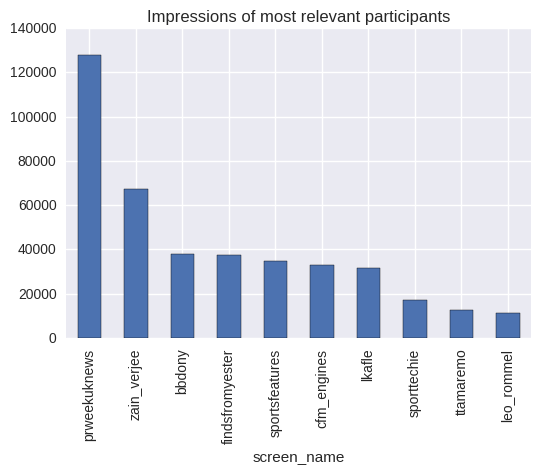

In [122]:
# Most influential participants

fig, ax = plt.subplots()
relevant_participants['impressions'].head(10).plot(ax=ax, kind='bar', title='Impressions of most relevant participants')

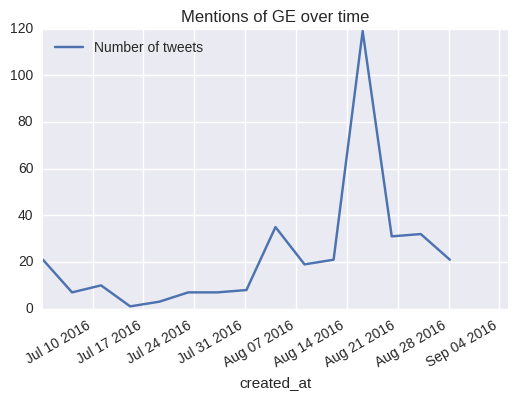

In [124]:
# Talk about GE over time

talk_about_ge = pd.DataFrame(exclude_ge['created_at'].map(pd.to_datetime))
talk_about_ge['Number of tweets'] = 1
talk_about_ge = talk_about_ge.fillna(0)
talk_about_ge = talk_about_ge.set_index('created_at')

talk_about_ge.resample('4D').sum().plot(kind='line', title='Mentions of GE over time')

# fig, ax = plt.subplots()
# relevant_participants['impressions'].head(10).plot(ax=ax, kind='bar')

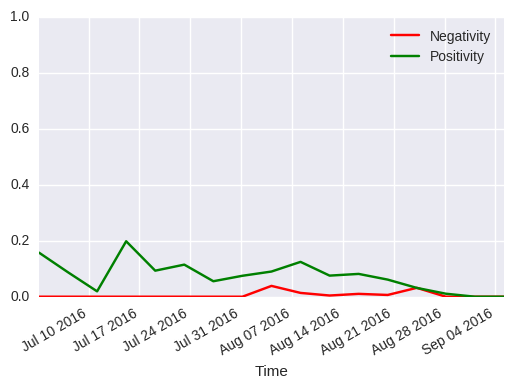

In [129]:
# Sentiment
corpus = dataset[['text_lower', 'created_at']]
sentiments = pd.DataFrame()

def get_sentiment(tweet):
    positive_value = tweet['pos']
    negative_value = tweet['neg']
    neutral_value = tweet['neu']
    
    tweet['pos'] = 0
    tweet['neu'] = 0
    tweet['neg'] = 0
    
    values = [positive_value, negative_value, neutral_value]
    
    if positive_value == max(values): tweet['pos'] = 1
    if negative_value == max(values): tweet['neg'] = 1
    if neutral_value == max(values): tweet['neu'] = 1

    return tweet
   
sentiment_values = pd.Series(corpus['text_lower'].map(lambda tweet: vaderSentiment(tweet.encode('utf-8'))))
sentiments['positive_val'] = sentiment_values.map(lambda x: x['pos'])
sentiments['negative_val'] = sentiment_values.map(lambda x: x['neg'])

sentiments['text'] = dataset['text_lower']

sentiments['date'] = pd.Series(corpus['created_at'].map(pd.to_datetime))

df = pd.DataFrame({'Time': sentiments['date'], 'Positivity': sentiments['positive_val'], 'Negativity': sentiments['negative_val']})
df = df.set_index('Time')
df = df.resample('4D').mean()
df = df.fillna(0)


color_arr = ['r', 'g']
df.plot(colors = color_arr, ylim=(0,1))

In [132]:
def process_tweet(tweet):
    processed_tweet = tweet.replace('rt','').replace('olympic', '')
    return ' '.join(filter(lambda x: x.lower() not in stopwords.words('english'), processed_tweet.split()))

processed_tweets = pd.Series(exclude_ge['text_lower'].map(process_tweet))

pd.Series(' '.join(processed_tweets).lower().split()).value_counts()[:100]

#rio2016                   79
sponsored                  78
@quazcreative:             74
(@generalelectric          74
cha)                       74
rio                        58
@gehealthcare:             56
#                          56
games                      52
2016                       50
#ge                        43
host                       41
htt…                       41
https://t.co/owzh4invzm    40
tend                       40
countries                  40
medals                     40
win                        40
ge                         37
https://t.…                35
@generalelectric           33
#s                         29
$ge                        27
games.                     26
every                      26
logo                       25
specially                  24
provides                   24
aircraft                   24
equipped                   24
                           ..
torch:                     13
bearing                    13
#droneweek